# Part 1: Data Setup

In [1]:
from pyspark.sql import SparkSession
import time
import pandas as pd
import matplotlib.pyplot as plt
import requests
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/28 04:31:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!wget https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip

--2023-03-28 04:32:02--  https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip’

hdma-wi-2021.zip    100%[===================>]  20.50M  16.8MB/s    in 1.2s    

2023-03-28 04:32:04 (16.8 MB/s) - ‘hdma-wi-2021.zip’ saved [21494278/21494278]

--2023-03-28 04:32:04--  https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144804 (141K) [application/zip]
Saving to: ‘arid2017_to_lei_xref_csv.zip’

arid2017_to_lei_xre 100%[===================>] 141.41K  --.-KB/s    in 0.07s   

2023-03-28 04:32:04 (1.87 MB/s)

In [3]:
!unzip code_sheets.zip -d code_sheets
!unzip arid2017_to_lei_xref_csv.zip -d arid2017_to_lei_xref_csv
!unzip hdma-wi-2021.zip -d hdma-wi-2021

Archive:  code_sheets.zip
  inflating: code_sheets/action_taken.csv  
  inflating: code_sheets/agency.csv  
  inflating: code_sheets/counties.csv  
  inflating: code_sheets/denial_reason.csv  
  inflating: code_sheets/edit_status.csv  
  inflating: code_sheets/ethnicity.csv  
  inflating: code_sheets/hoepa.csv   
  inflating: code_sheets/lien_status.csv  
  inflating: code_sheets/loan_purpose.csv  
  inflating: code_sheets/loan_type.csv  
  inflating: code_sheets/msamd.csv   
  inflating: code_sheets/owner_occupancy.csv  
  inflating: code_sheets/preapproval.csv  
  inflating: code_sheets/property_type.csv  
  inflating: code_sheets/purchaser_type.csv  
  inflating: code_sheets/race.csv    
  inflating: code_sheets/sex.csv     
  inflating: code_sheets/states.csv  
  inflating: code_sheets/tracts.csv  
Archive:  arid2017_to_lei_xref_csv.zip
  inflating: arid2017_to_lei_xref_csv/arid2017_to_lei_xref_csv.csv  
Archive:  hdma-wi-2021.zip
  inflating: hdma-wi-2021/hdma-wi-2021.csv  


In [4]:
!hdfs dfs -cp code_sheets hdfs://main:9000/code_sheets
!hdfs dfs -cp hdma-wi-2021 hdfs://main:9000/hdma-wi-2021
!hdfs dfs -cp arid2017_to_lei_xref_csv hdfs://main:9000/arid2017_to_lei_xref_csv

In [5]:
for name in [ "ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]:
    df = spark.read.format("csv").option("header", True).option("inferSchema", True).load(f"hdfs://main:9000/code_sheets/{name}.csv")
    df.createOrReplaceTempView(name)

In [6]:
df = spark.read.format("csv").option("header", True).option("inferSchema", True).load("hdfs://main:9000/arid2017_to_lei_xref_csv/arid2017_to_lei_xref_csv.csv")
df.write.saveAsTable("banks", mode="overwrite")
spark.read.csv(f"hdfs://main:9000/hdma-wi-2021/hdma-wi-2021.csv", header=True, inferSchema=True).write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

23/03/28 04:32:51 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/03/28 04:32:51 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/03/28 04:32:55 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/03/28 04:32:55 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.20.0.3
23/03/28 04:32:56 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/03/28 04:32:56 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/03/28 04:32:57 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/banks; Force to delete it.
23/03/28 04:32:57 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/banks
23/03/28 04:33:00 WARN Sessio

In [7]:
# Q1
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



# Part 2: Filter and Join

In [8]:
# Q2
result = spark.sql("""
SELECT COUNT(*)
FROM banks
WHERE LOWER(respondent_name) LIKE '%first%'
""").toPandas()

print("Number of banks containing the word 'first' in their name:", result.iloc[0,0])

spark.sql("""
SELECT *
FROM banks
WHERE LOWER(respondent_name) LIKE '%second%'
""").toPandas()

Number of banks containing the word 'first' in their name: 525


,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,Old Second National Bank,14596,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08


In [9]:
# Q3
# My bank name: University of Wisconsin Credit Union
results = spark.sql("""
SELECT COUNT(*)
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
WHERE respondent_name like 'JPMorgan Chase Bank, National Association'
""")
results.toPandas()

,count(1)
0,8178


In [10]:
# Q4
# 1. The banks table is sent to every executor 
# 2. Both the banks and loans
# 3. partial_count(1) and count(1)
results.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildRight (10)
                  :- * Filter (3)
                  :  +- * ColumnarToRow (2)
                  :     +- Scan parquet default.loans (1)
                  +- BroadcastQueryStage (9)
                     +- BroadcastExchange (8)
                        +- * Project (7)
                           +- * Filter (6)
                              +- * ColumnarToRow (5)
                                 +- Scan parquet default.banks (4)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildRight (20)
               :- Filter (16)
               :  +- Scan parquet default.loans (1)
               +- BroadcastExchange (19)
            

In [11]:
# Q5
spark.sql("""
SELECT census_tract, county, loan_purpose.loan_purpose, derived_dwelling_category, loan_amount/1000 AS thousands, interest_rate, loan_term/12 AS years, action_taken.action_taken
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
LEFT JOIN loan_purpose ON loans.loan_purpose = loan_purpose.id
LEFT JOIN action_taken ON loans.action_taken = action_taken.id
LEFT JOIN (
    SELECT CONCAT(LPAD(CAST(STATE AS string),2,'0'), LPAD(CAST(COUNTY AS string),3,'0')) AS county_code_2, NAME AS county
    FROM (
        SELECT DISTINCT STATE, COUNTY, NAME
        FROM counties
        )
) ON loans.county_code = county_code_2
WHERE respondent_name LIKE 'JPMorgan Chase Bank, National Association' AND action_taken.action_taken LIKE 'Loan originated'
ORDER BY loan_amount DESC
LIMIT 10
""").toPandas()

,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55133203500,Waukesha,None,Single Family (1-4 Units):Site-Built,12915.0,2.75,30.0,Loan originated
1,55059000100,Kenosha,None,Multifamily:Site-Built,4975.0,3.38,30.0,Loan originated
2,55079012800,Milwaukee,None,Multifamily:Site-Built,4605.0,3.36,30.0,Loan originated
3,55127001602,Walworth,None,Single Family (1-4 Units):Site-Built,4555.0,2.75,30.0,Loan originated
4,55079185400,Milwaukee,None,Multifamily:Site-Built,3625.0,4.94,20.5,Loan originated
5,55127001602,Walworth,Home purchase,Single Family (1-4 Units):Site-Built,3535.0,2.875,30.0,Loan originated
6,55133204100,Waukesha,None,Single Family (1-4 Units):Site-Built,3305.0,2.625,30.0,Loan originated
7,55079019400,Milwaukee,None,Multifamily:Site-Built,3105.0,3.48,25.0,Loan originated
8,55127001602,Walworth,None,Single Family (1-4 Units):Site-Built,3005.0,3.125,30.0,Loan originated
9,55133203500,Waukesha,Home purchase,Single Family (1-4 Units):Site-Built,3005.0,2.25,30.0,Loan originated


# Part 3: GROUPY BY and Windowing

In [12]:
# Q6
# The network transfer is necessary for the query that uses "GROUP BY loan_purpose", while the other is not.
# I think it's because I divided the loans table into 8 buckets by the county_code column when I loaded it.
spark.sql("""
SELECT loan_purpose, MEAN(loan_amount)
FROM loans
GROUP BY loan_purpose
""").explain()

spark.sql("""
SELECT county_code, lei, MEAN(loan_amount)
FROM loans
GROUP BY county_code, lei
""").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[loan_purpose#979], functions=[mean(loan_amount#984)])
   +- Exchange hashpartitioning(loan_purpose#979, 200), ENSURE_REQUIREMENTS, [plan_id=1116]
      +- HashAggregate(keys=[loan_purpose#979], functions=[partial_mean(loan_amount#984)])
         +- FileScan parquet default.loans[loan_purpose#979,loan_amount#984] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://main:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<loan_purpose:int,loan_amount:double>


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#967, lei#964], functions=[mean(loan_amount#984)])
   +- HashAggregate(keys=[county_code#967, lei#964], functions=[partial_mean(loan_amount#984)])
      +- FileScan parquet default.loans[lei#964,county_code#967,loan_amount#984] Batched: true, DataFilters: [], Format: Parquet, Location: 

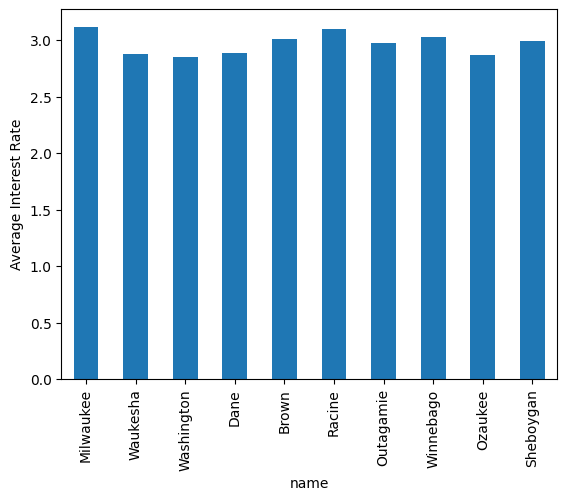

In [13]:
# Q7
df = spark.sql("""
SELECT county as name, MEAN(interest_rate) AS mean
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
LEFT JOIN (
    SELECT CONCAT(LPAD(CAST(STATE AS string),2,'0'), LPAD(CAST(COUNTY AS string),3,'0')) AS county_code_2, NAME AS county
    FROM (
        SELECT DISTINCT STATE, COUNTY, NAME
        FROM counties
        )
) ON loans.county_code = county_code_2
WHERE respondent_name LIKE 'Wells Fargo Bank, National Association'
GROUP BY county
ORDER BY COUNT(*) DESC
LIMIT 10
""").toPandas().set_index('name').plot.bar(legend=None, ylabel = "Average Interest Rate")

<Axes: xlabel='name', ylabel='2nd Biggest Loan Application (Millions $)'>

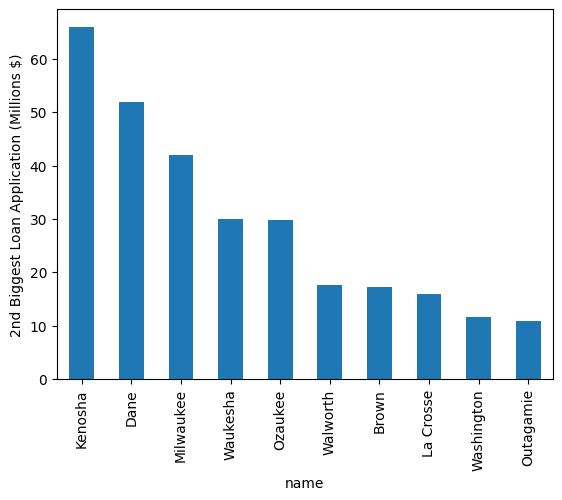

In [14]:
# Q8
spark.sql("""
SELECT DISTINCT county as name,
    NTH_VALUE(loan_amount/1000000, 2) OVER (PARTITION BY county ORDER BY loan_amount DESC) as amount 
FROM loans
LEFT JOIN (
    SELECT CONCAT(LPAD(CAST(STATE AS string),2,'0'), LPAD(CAST(COUNTY AS string),3,'0')) AS county_code_2, NAME AS county
    FROM (
        SELECT DISTINCT STATE, COUNTY, NAME
        FROM counties
        )
) ON loans.county_code = county_code_2
WHERE county NOT like 'none'
ORDER BY amount DESC
LIMIT 10
""").toPandas().set_index('name').plot.bar(legend=None, ylabel = "2nd Biggest Loan Application (Millions $)")

In [15]:
df = spark.sql(""" 
SELECT interest_rate
FROM banks
INNER JOIN loans
ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
""")

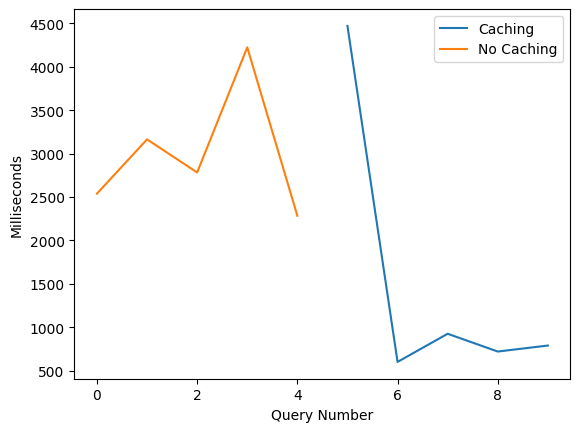

In [16]:
# Q9
times_df = pd.DataFrame(dtype=float)
for i in range(10):
    if i == 5:
        df.cache()
    t0 = time.time()
    df.count()
    t1 = time.time()
    times_df.at[i, "Milliseconds"] = (t1 - t0)* 1e3
    if i < 5:
        times_df.at[i, "Type"] = 'No Caching'
    else:
        times_df.at[i, "Type"] = 'Caching'


groups = times_df.groupby('Type')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group['Milliseconds'], label=name)
ax.set_xlabel("Query Number")
ax.set_ylabel("Milliseconds")
ax.legend()
plt.show()

<Axes: xlabel='Query Number', ylabel='Task Count'>

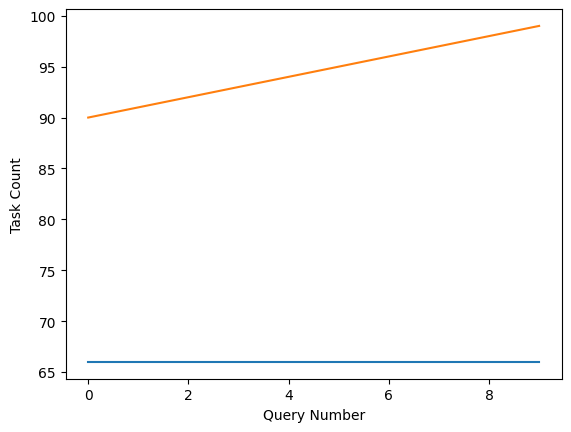

In [21]:
# Q10
tasks_df = pd.DataFrame(dtype=int)
df = df.repartition(1)
df.cache()
r = requests.get("http://localhost:4040/api/v1/applications")
r.raise_for_status()
app_id = r.json()[0]["id"]

for i in range(10):
    df.count()
    r = requests.get(f"http://localhost:4040/api/v1/applications/{app_id}/executors")
    r.raise_for_status()
    tasks_df.at[i, 'exe1'] = r.json()[1]['completedTasks']
    tasks_df.at[i, 'exe2'] = r.json()[2]['completedTasks']

tasks_df.plot.line(legend=None, xlabel = "Query Number", ylabel = "Task Count")